# Feed-forward neural network using ozone data at Joshua Tree
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/ml_tutorial_csu/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/ml_tutorial_csu/blob/main/code/ann_ozone_joshuatree_metrics.ipynb)

* Created by TA Jamin Rader [CSU] for ATS 780A7 Spring 2022 at Colorado State University led by Prof. Elizabeth Barnes; modified for the CSU-PCMDI 2022 Machine learning workshop by Elina Valkonen and Marybeth Arcodia

# 0. Set Up Environments

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = True


In [2]:
import sys
import numpy as np
import seaborn as sb

import pandas as pd
import datetime
import tensorflow as tf
#import tensorflow.keras as keras
import sklearn
#import pydot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# %matplotlib inline

tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")  

python version = 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
numpy version = 1.21.6
tensorflow version = 2.8.0


In [4]:
# if(IN_COLAB==True):
#     try:
#         from google.colab import drive
#         drive.mount('/content/drive', force_remount=True)
#         local_path = '/content/drive/My Drive/Colab Notebooks/'
#     except:
#         local_path = './'
# else:
#     local_path = '../figures/'

# 1. Data Preparation

### 1.1 Data Overview

This is ozone and meteorlogical data from [CASTNET](https://www.epa.gov/castnet) (Clean Air Status and Trends Network) for Joshua Tree National Park, located just outside of Palm Springs and about 100 miles east of Los Angeles. The National Park Service monitors ozone in their parks. Joshua Tree has recorded at least 30 exceedance days per year [since 2016](https://www.nps.gov/subjects/air/ozone-exceed.htm). An exceedance day occurs when the daily maximum 8-hour ozone average is 71 ppb or higher. For comparison, Rocky Mountain NP has only experienced 35 ozone exceedance days since 2016.





In [5]:
# Read in data from url
url = "https://raw.githubusercontent.com/eabarnes1010/course_ml_ats/main/data/ozone_data_joshuatreenp.csv"
data = pd.read_csv(url,parse_dates=["DATE_TIME"],infer_datetime_format=True)

# Fix data issue with Daylight Savings Time
duplicate_dates = data['DATE_TIME'][data.duplicated('DATE_TIME')]
for dup_date in duplicate_dates:
  idx = data['DATE_TIME'].eq(dup_date).idxmax()
  data.at[idx, 'DATE_TIME'] = dup_date - pd.Timedelta(value=1, unit='hours')  

# Add hour and day of year
data['HOUR'] = data['DATE_TIME'].dt.hour
data['MONTH'] = data['DATE_TIME'].dt.month
data['YEAR'] = data['DATE_TIME'].dt.year
data['DAYOFYEAR'] = data['DATE_TIME'].dt.dayofyear
data.sort_values('DATE_TIME', inplace=True, ignore_index = True)

Let's take a look at the data. We have data for ozone, temperature, relative humidity, and wind direction, among others.

In [6]:
display(data.head())

,SITE_ID,DATE_TIME,TEMPERATURE,TEMPERATURE_DELTA,RELATIVE_HUMIDITY,SOLAR_RADIATION,OZONE,PRECIPITATION,WINDSPEED,WIND_DIRECTION,SIGMA_THETA,FLOW_RATE,WINDSPEED_SCALAR,UPDATE_DATE,HOUR,MONTH,YEAR,DAYOFYEAR
0,JOT403,2010-01-01 00:00:00,3.4000,2.4000,29.0,0.0,46.0,0.0,3.8000,189.0,2.0,3.05,3.8000,10/30/14 10:27,0,1,2010,1
1,JOT403,2010-01-01 01:00:00,3.4000,2.5999,29.0,0.0,46.0,0.0,3.2000,189.0,5.0,3.05,3.2000,10/30/14 10:27,1,1,2010,1
2,JOT403,2010-01-01 02:00:00,3.5999,2.7000,26.0,0.0,46.0,0.0,3.5000,191.0,4.0,3.05,3.5000,10/30/14 10:27,2,1,2010,1
3,JOT403,2010-01-01 03:00:00,3.3000,2.8000,28.0,0.0,46.0,0.0,3.0999,190.0,5.0,3.05,3.0999,10/30/14 10:27,3,1,2010,1
4,JOT403,2010-01-01 04:00:00,3.2000,2.5999,32.0,0.0,45.0,0.0,3.5999,191.0,4.0,3.05,3.5999,10/30/14 10:27,4,1,2010,1


### 1.2 Define Input and Output

The 2015 benchmark for [human health ozone condition](https://www.nps.gov/articles/analysis-methods2020.htm) is shown here. Let us predict whether the ozone quality will be classified as good, fair, or poor over 8-hour periods.

**Good**   $\leq$ 54.9 ppb

**Fair**   55.0 - 70.9 ppb

**Poor**   $\geq$ 71.0 ppb

Let's start out by training our model using Temperature, Relative Humidity, Windspeed, and Day of Year.

In [7]:
# Here are all the different variables that we could use for training our neural
# nework (except ozone, of course)
data.columns

Index(['SITE_ID', 'DATE_TIME', 'TEMPERATURE', 'TEMPERATURE_DELTA',
       'RELATIVE_HUMIDITY', 'SOLAR_RADIATION', 'OZONE', 'PRECIPITATION',
       'WINDSPEED', 'WIND_DIRECTION', 'SIGMA_THETA', 'FLOW_RATE',
       'WINDSPEED_SCALAR', 'UPDATE_DATE', 'HOUR', 'MONTH', 'YEAR',
       'DAYOFYEAR'],
      dtype='object')

Let's take a quick look at all of our data

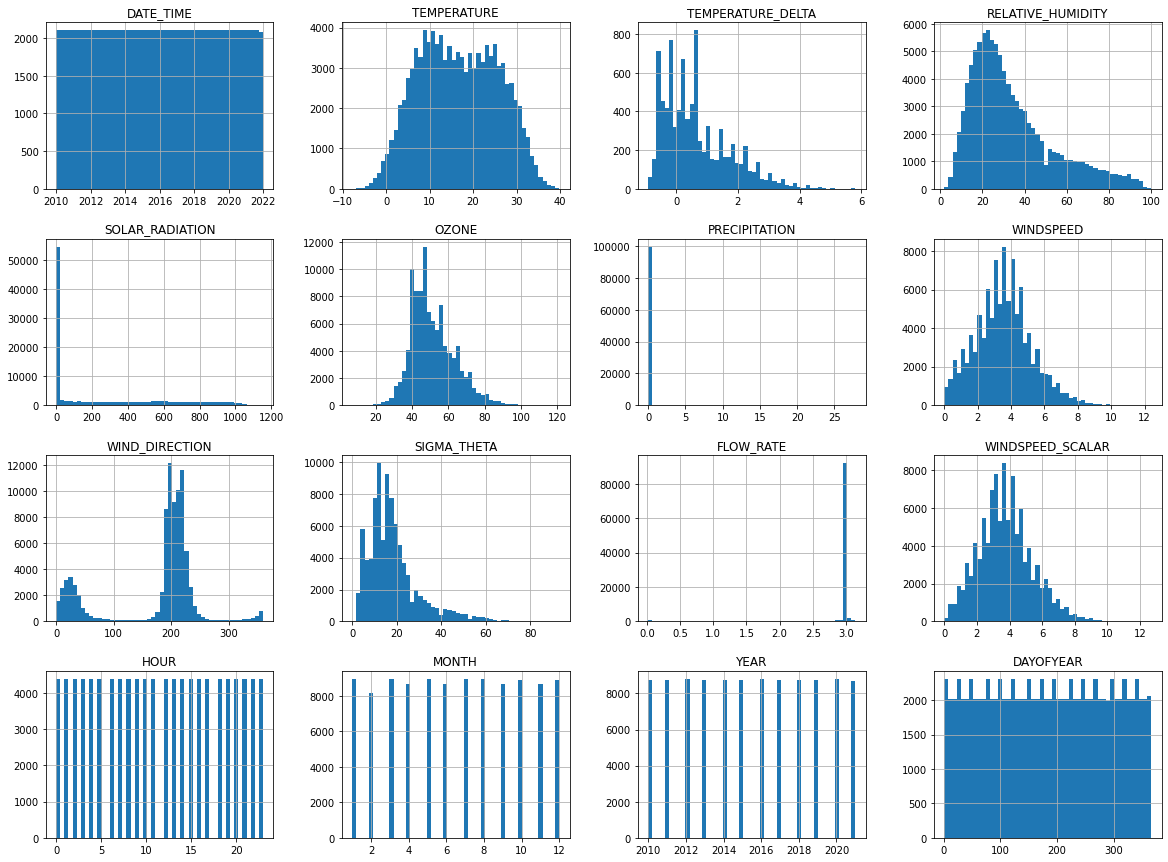

In [8]:
data.hist(bins=50, figsize=(20,15))
plt.show()

Next we will look for correlations between the different variables and ozone

In [9]:
corr_matrix = data.corr()

corr_matrix["OZONE"].sort_values(ascending=False)


OZONE                1.000000
TEMPERATURE          0.580335
SOLAR_RADIATION      0.219830
HOUR                 0.166332
WIND_DIRECTION       0.153232
WINDSPEED_SCALAR     0.147250
WINDSPEED            0.134915
FLOW_RATE            0.056294
SIGMA_THETA         -0.010013
MONTH               -0.062331
DAYOFYEAR           -0.065363
PRECIPITATION       -0.066687
YEAR                -0.106410
TEMPERATURE_DELTA   -0.150360
RELATIVE_HUMIDITY   -0.466586
Name: OZONE, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ff8256490>,
      dtype=object)

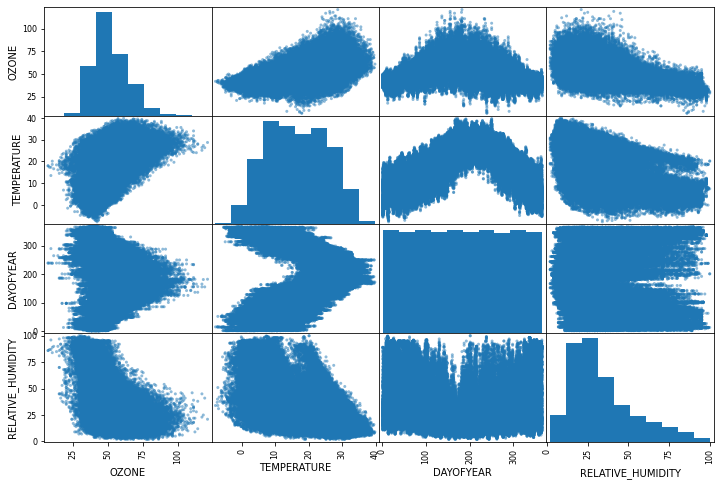

In [10]:
from pandas.plotting import scatter_matrix

attributes = ["OZONE", "TEMPERATURE", "DAYOFYEAR",
              "RELATIVE_HUMIDITY"]
scatter_matrix(data[attributes], figsize=(12, 8))

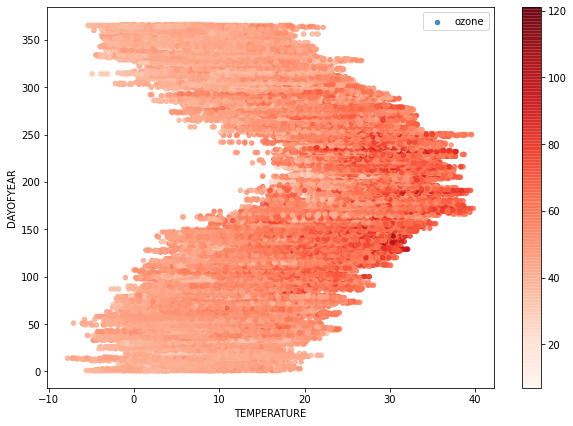

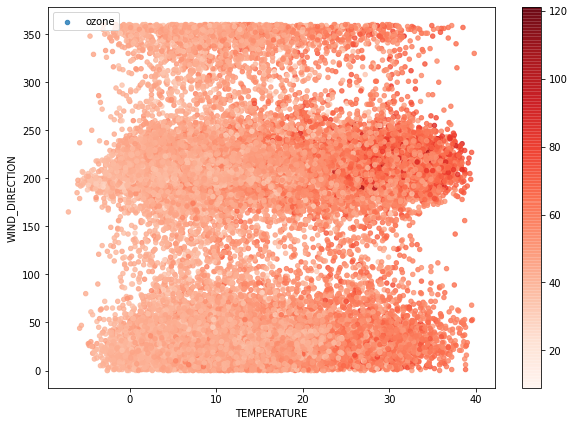

In [11]:


data.plot(kind="scatter", x="TEMPERATURE", y="DAYOFYEAR", alpha=0.8,
             s=20, label="ozone", figsize=(10,7),
             c=data["OZONE"], cmap=plt.get_cmap("Reds"), colorbar=True,
             sharex=False)
plt.legend()


data.plot(kind="scatter", x="TEMPERATURE", y="WIND_DIRECTION", alpha=0.8,
             s=20, label="ozone", figsize=(10,7),
             c=data["OZONE"], cmap=plt.get_cmap("Reds"), colorbar=True,
             sharex=False)
plt.legend()

**EDIT the Input Variables Here:** Reminder, if you choose to use wind direction, you must first convert it to a vector for averaging.

In [12]:
# List of strings from the available column names in the data set
INPUT_VARIABLES = ['TEMPERATURE', 'RELATIVE_HUMIDITY', 
                   'WINDSPEED', 'DAYOFYEAR',]

In [13]:
# Let's isolate our variables of interest and take the 8-hour running mean

# First using input and output variables together to take running mean
df_data_to_be_used = data[['OZONE'] + INPUT_VARIABLES] 

# Here we take the 8-hour rolling mean (note: DATE_TIME does not work)
df_data_to_be_used = df_data_to_be_used.rolling(8).mean()

# Now adding Date and Time components
df_data_to_be_used[['DATE_TIME', 'HOUR', 'MONTH', 'YEAR']] = \
    data[['DATE_TIME', 'HOUR', 'MONTH', 'YEAR']] 

# Dropping NaNs
df_data_to_be_used.dropna(inplace=True)

display(df_data_to_be_used.head())

,OZONE,TEMPERATURE,RELATIVE_HUMIDITY,WINDSPEED,DAYOFYEAR,DATE_TIME,HOUR,MONTH,YEAR
7,45.125,3.299987,30.875,3.337462,1.0,2010-01-01 07:00:00,7,1,2010
8,45.125,3.749988,30.875,2.899962,1.0,2010-01-01 08:00:00,8,1,2010
9,45.375,4.374975,30.500,2.649962,1.0,2010-01-01 09:00:00,9,1,2010
10,45.625,5.074975,30.375,2.387462,1.0,2010-01-01 10:00:00,10,1,2010
11,46.000,5.862475,29.875,2.249975,1.0,2010-01-01 11:00:00,11,1,2010


In [14]:
# Creating a numpy array for our inputs and outputs
input = df_data_to_be_used[INPUT_VARIABLES].values
output_raw = df_data_to_be_used['OZONE'].values

# Creating numpy arrays for time/date info for visualizations
hour = df_data_to_be_used['HOUR'].values
month = df_data_to_be_used['MONTH'].values
year = df_data_to_be_used['YEAR'].values

# Turning ozone into classification problem:
  # Class 0: Good, Class 1: Fair, Class 2: Poor
output_class = (output_raw >= 55).astype(int) + (output_raw >= 71).astype(int)
output = (output_class.reshape(-1,1) == np.unique(output_class)).astype(int)

# Here is how our data is encoded into classes.
print("Good")
print('Ozone Value:', output_raw[0])
print('Ozone Class:', output_class[0])
print('Encoded As:', output[0])
print()
print("Fair")
print('Ozone Value:', output_raw[2000])
print('Ozone Class:', output_class[2000])
print('Encoded As:', output[2000])
print()
print("Poor")
print('Ozone Value:', output_raw[1770])
print('Ozone Class:', output_class[1770])
print('Encoded As:', output[1770])

Good
Ozone Value: 45.125
Ozone Class: 0
Encoded As: [1 0 0]

Fair
Ozone Value: 58.0
Ozone Class: 1
Encoded As: [0 1 0]

Poor
Ozone Value: 73.125
Ozone Class: 2
Encoded As: [0 0 1]


In [15]:
# Printing the shapes of our input and output arrays (#samples , #dimension of input/output)
print('Input Array Shape:', input.shape)
print('Output Array Shape:', output.shape)

Input Array Shape: (92409, 4)
Output Array Shape: (92409, 3)


### 1.3 Visualizing our Data

Let's start with our input data and do some very basic plotting to get an idea of our variables

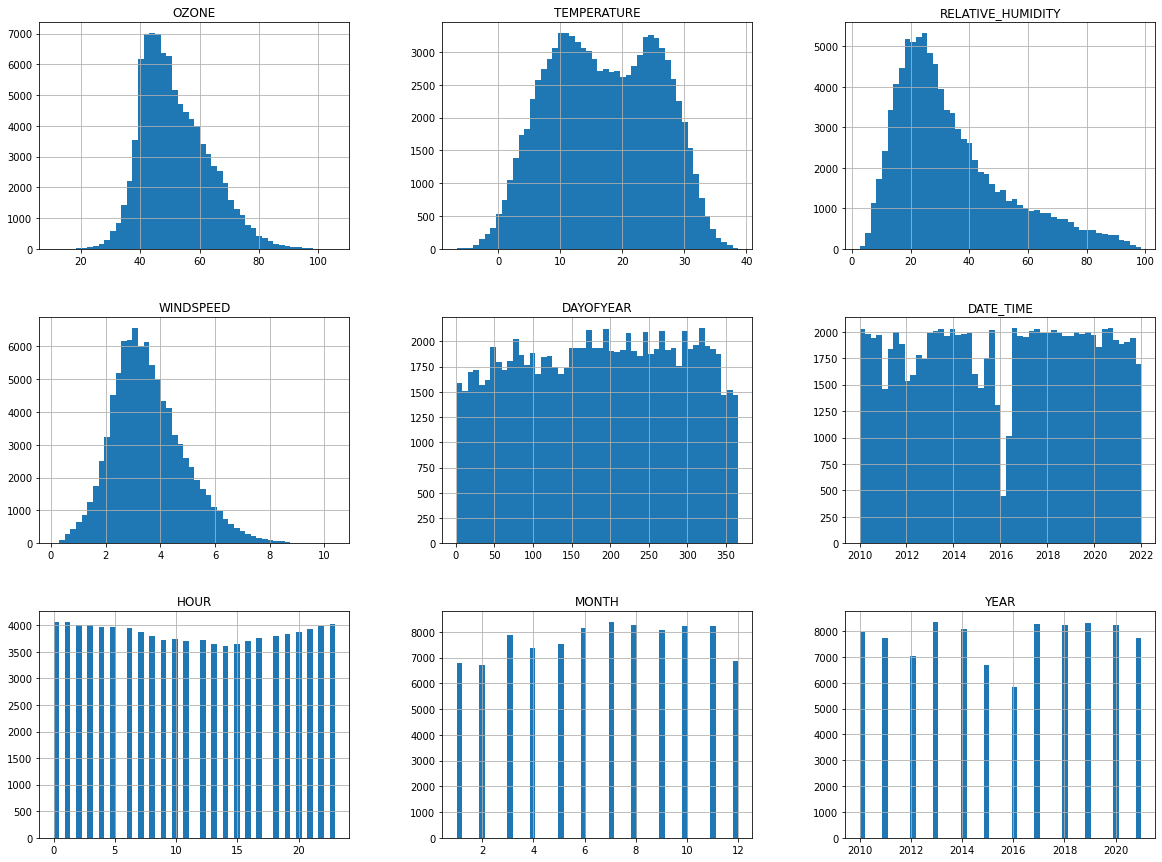

In [16]:
df_data_to_be_used.hist(bins=50, figsize=(20,15))
plt.show()

Let's look at what our output data actually looks like.

In [17]:
# How often does our data fall into each category?
calcpercent = lambda cat: str((np.sum(output_class == cat)/len(output_class)*100).astype(int))

# Print out the sizes of each class
print('Frequency for each Ozone Category')
print('Good: ' + calcpercent(0) + '%')
print('Fair: ' + calcpercent(1) + '%')
print('Poor: ' + calcpercent(2) + '%')

Frequency for each Ozone Category
Good: 65%
Fair: 28%
Poor: 6%


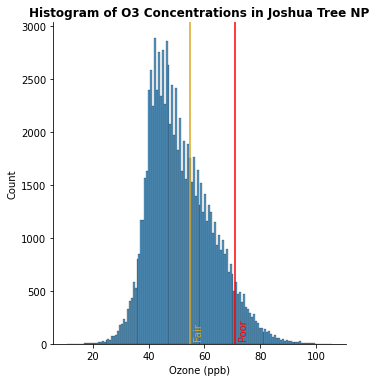

In [18]:
# Distribution of ozone concentrations
sb.displot(output_raw, kind='hist')
plt.xlabel('Ozone (ppb)')
plt.axvline(x=71, color='red')
plt.axvline(x=55, color='goldenrod')
plt.text(56, 50, 'Fair', rotation=90, color='goldenrod')
plt.text(72, 50, 'Poor', rotation=90, color='red')

plt.title('Histogram of O3 Concentrations in Joshua Tree NP', fontweight='demi')
plt.plot()
plt.show()

O3 Concentrations in Each Month


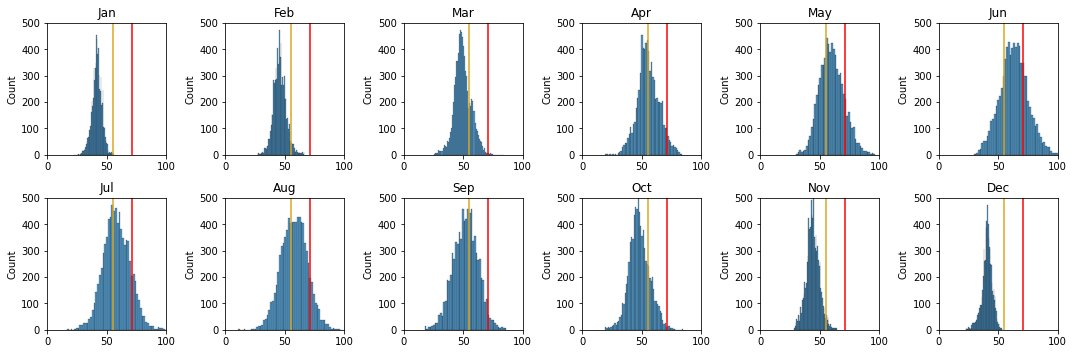

In [19]:
# Distribution of ozone concentrations in each month

fig, axs = plt.subplots(2, 6, figsize = (15,5))

for m in np.arange(12):
  ax = axs[m//6,m%6]
  sb.histplot(output_raw[month == m+1], ax=ax)
  ax.set_title(datetime.datetime.strptime(str(m+1), "%m").strftime("%b"))
  ax.axvline(x=71, color='red')
  ax.axvline(x=55, color='goldenrod')
  ax.set_xlim(0,100)
  ax.set_ylim(0,500)

fig.tight_layout(pad=1.0)
print('O3 Concentrations in Each Month')

O3 Concentrations in Each Year


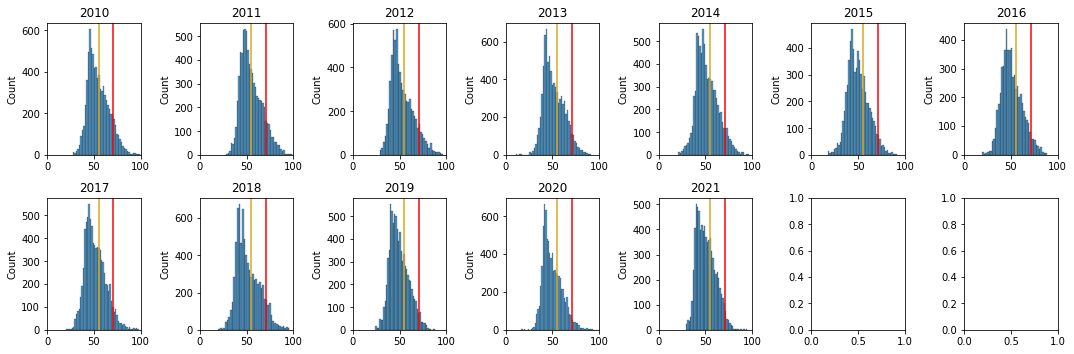

In [20]:
# Distribution of ozone concentrations in each year

fig, axs = plt.subplots(2, 7, figsize = (15,5))

axidx = 0
for y in np.unique(year):
  ax = axs[axidx//7,axidx%7]
  sb.histplot(output_raw[year == y], ax=ax)
  ax.set_title(y)
  ax.axvline(x=71, color='red')
  ax.axvline(x=55, color='goldenrod')
  ax.set_xlim(0,100)
  axidx+=1

fig.tight_layout(pad=1.0)
print('O3 Concentrations in Each Year')

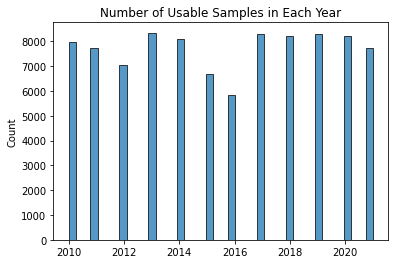

In [21]:
# How many samples are available in each year? Data cannot be used if 
# there are NaNs (see 2013)
sb.histplot(year)
plt.title('Number of Usable Samples in Each Year');

### 1.4 Partitioning Data in Training, Validation, and Testing Sets

Our data is highly temporally correlated, so we are going to separate training, validation, and testing by grabbing different years of data. *Not* by random sampling.

**Some Variable Definitions**

* ```Xtrain/Xval/Xtest:*** 2-D Arrays of input data (shape: #samples, #input_variables)```

* ```Ttrain/Tval/Ttest:*** 2-D Arrays of target output data (true ozone class likelihood; shape: #samples, #classes)```

* ```Ptrain/Pval/Ptest:*** 2-D Arrays of predicted output data (predicted ozone class likelihoods; shape: #samples, #classes)```

* ```Xtrain_raw/Xval_raw/Xtest_raw:*** 2-D Arrays of raw (pre-standardized) input data (shape: #samples, #input_variables)```

* ```O3train/O3val/O3test:*** 1-D Arrays of raw ozone measurements (ppb; shape: #samples)```

* ```Cttrain/Ctval/Cttest:*** 1-D Arrays of the true ozone class (shape: #samples)```

* ```Cptrain/Cpval/Cptest:*** 1-D Arrays of the predicted ozone class with the highest likelihood (shape #samples)```

**EDIT the years used for training, validation and testing here:**

In [22]:
# Using the years 2010 - 2017 for training, 2018-2019 for validation, and 2020-2021 for testing
TRAIN_RANGE = (2010, 2017)
VAL_RANGE = (2018, 2019)
TEST_RANGE = (2020, 2021)

In [23]:
# Splitting into training, testing, validation

# This function returns a boolean array of years that fall within the given year range
year_bool = lambda yrrange: np.logical_and(year>=yrrange[0], year<=yrrange[1])

# Create the input and output arrays from training, testing, validation sets
# Inputs haven't been standardized yet (thus "_raw")

Xtrain_raw = input[year_bool(TRAIN_RANGE)] # these are the inputs (X)
Ttrain = output[year_bool(TRAIN_RANGE)] # these are the outputs (T is for target)

Xval_raw = input[year_bool(VAL_RANGE)]
Tval = output[year_bool(VAL_RANGE)]

Xtest_raw = input[year_bool(TEST_RANGE)]
Ttest = output[year_bool(TEST_RANGE)]

# These are the raw outputs in each set for use later
O3train = output_raw[year_bool(TRAIN_RANGE)]
O3val = output_raw[year_bool(VAL_RANGE)]
O3test = output_raw[year_bool(TEST_RANGE)]

print('Shapes:')
print('  Xtrain: ', Xtrain_raw.shape)
print('  Xval: ', Xval_raw.shape)
print('  Xtest: ', Xtest_raw.shape)
print('  Ttrain: ', Ttrain.shape)
print('  Tval: ', Tval.shape)
print('  Ttest: ', Ttest.shape)

Shapes:
  Xtrain:  (59957, 4)
  Xval:  (16512, 4)
  Xtest:  (15940, 4)
  Ttrain:  (59957, 3)
  Tval:  (16512, 3)
  Ttest:  (15940, 3)


In [24]:
# Standardizing the training, testing, and validation data

# This function takes a raw set of input fields (for example, the training, 
# validation, or testing arrays), and standardizes it based on the training data.

standardize_input = lambda dat, x, s: (dat - x)/s 

# Calculate mean and standard deviation of the training data
trainmean = Xtrain_raw.mean(axis=0) 
trainstd  = Xtrain_raw.std(axis=0) 

Xtrain = standardize_input(Xtrain_raw, trainmean, trainstd)
Xval = standardize_input(Xval_raw, trainmean, trainstd)
Xtest = standardize_input(Xtest_raw, trainmean, trainstd)

# 2. Neural Network

### 2.1 Building the Model

In [25]:
# Let's import some different things we will use to build the neural network
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Softmax

In [26]:
### Here is where we actually build the model

def compile_model():
  # This isn't good practice, but model will be a global variable
  global model

  # First we start with an input layer
  input_layer = Input(shape=Xtrain[0].shape) # size per sample, equal to number of features

  # Let's apply dropout to the input layer. (If Dropout(0), Dropout isn't being used)
  layers = Dropout(0)(input_layer)

  # Now let's add a few layers. We are going to do two layers with 5 nodes each.
  # Each uses the 'relu' activation function and randomizes the initial weights/biases
  # Dropout may be useful for hidden layers if the number of hidden nodes is large
  # If Dropout(0), Dropout isn't being used.

  for hidden, activation in zip(HIDDENS, ACTIVATIONS):
    layers = Dense(hidden, activation=activation,
                   bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                   kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)
    
    layers = Dropout(0)(layers)

  # Output layer has a softmax function to convert output to class likelihood
  output_layer = Dense(Ttrain.shape[1], activation='softmax',
                      bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                      kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)

  # Constructing the model
  model = Model(input_layer, output_layer)
  optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # Using the Adam optimizer
  model.compile(optimizer=optimizer, loss=LOSS, 
                metrics=[tf.keras.metrics.CategoricalAccuracy()])
  
  model.summary()


### This is the function that will iteratively train the model

def fit_model():
  global history
  history = model.fit(Xtrain, Ttrain, 
                      epochs=NUM_EPOCHS, 
                      verbose=VERBOSITY,
                      batch_size = BATCH_SIZE, shuffle=True,
                      validation_data=[Xval, Tval],
                      class_weight = CLASS_WEIGHT, 
                      callbacks=[EARLY_STOPPING])

### 2.2 Training the Model

In [27]:
# This builds, compiles, then fits, the model. 
# It's important to recompile the model each time before fitting.

def train_model():
  compile_model()
  fit_model()

**EDIT the model hyperparameters here**

In [28]:
### Here are some model architecture hyperparameters we can mess with

SEED = 28980 # used for setting random values so results are reproducable

HIDDENS = [3, 3] # Number of hidden nodes in each layer of the model (list of ints)
ACTIVATIONS = ['relu'] * len(HIDDENS) # Activation function used in the hidden layers (list of strs)

### Here are some training options
NUM_EPOCHS = 300 # Max number of times all of the data will be seen iteratively in training
BATCH_SIZE = 256 # Number of samples
VERBOSITY = 0 # 0: Silent during model.fit; 1: Progress bar; 2: Prints each epoch
LEARNING_RATE = .001 # Learning rate (think step size)
LOSS = 'categorical_crossentropy' # Loss function
#LOSS = tf.keras.losses.CategoricalHinge()

### Here we can change how much the loss function takes into consideration different classes
CLASS_WEIGHT = {0 : 1 / np.mean(Ttrain[:,0] == 1),
                1 : 1 / np.mean(Ttrain[:,1] == 1),
                2 : 1 / np.mean(Ttrain[:,2] == 1)}

#CLASS_WEIGHT = {0 : 1, 1 : 1, 2 : 1}

### Early Stopping
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=20,
                                                   verbose=1,
                                                   mode='auto',
                                                   restore_best_weights=True)

# Setting a random seeds so results are reproducable
np.random.seed(SEED)
import random
random.seed(SEED)

try: # tensorflow 2
  tf.random.set_seed(SEED)
except: # tf1
  tf.set_random_seed(SEED)

########################################################
### TRAIN THE MODEL ####################################
########################################################

# Training the model
train_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 3)                 15        
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dropout_2 (Dropout)         (None, 3)                 0         
                                                                 
 dense_2 (Dense)             (None, 3)                 12    

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Restoring model weights from the end of the best epoch: 45.
Epoch 65: early stopping


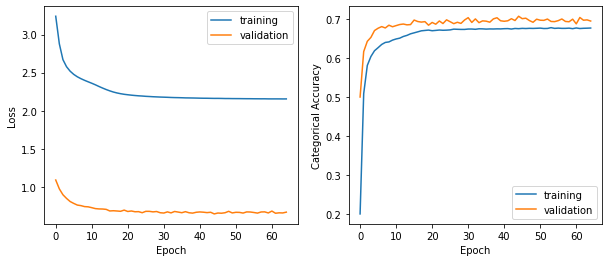

In [29]:
# Let's plot the change in loss and categorical_accuracy

fig, axs = plt.subplots(1, 2, figsize = (10,4))

axs[0].plot(history.history['loss'], label='training')
axs[0].plot(history.history['val_loss'], label='validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history.history['categorical_accuracy'], label='training')
axs[1].plot(history.history['val_categorical_accuracy'], label='validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Categorical Accuracy')
axs[1].legend();

In [30]:
# What predictions did the model make for our training, validation, and test sets?
Ptrain = model.predict(Xtrain) # Array of class likelihoods for each class
Pval = model.predict(Xval)
Ptest = model.predict(Xtest)

Cptrain = Ptrain.argmax(axis=1) # 1-D array of predicted class (highest likelihood)
Cpval = Pval.argmax(axis=1)
Cptest = Ptest.argmax(axis=1)

Cttrain = Ttrain.argmax(axis=1) # 1-D array of truth class
Ctval = Tval.argmax(axis=1)
Cttest = Ttest.argmax(axis=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


### 2.3 Model Performance
How should we evaluate our ANN's performance? Categorical accuracy is one way, which tells us how often any class was correctly predicted. However, by this metric, since 65% of our data points are from days with "Good" ozone, our model could learn to predict "Good" every time and we would still be 65% accurate. This doesn't allow us to learn anything about what it takes to predict "Fair" or "Poor" ozone days. Below, we compare categorical accuracy, to weighted categorical accuracy which takes into account class imbalances.

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print('Validation Categorical Accuracy:', accuracy_score(Ctval, Cpval) )

# Weight equal to the inverse of the frequency of the class
cat_weights = np.sum((1 / np.mean(Ttrain, axis=0)) * Tval, axis=1) 
print('Validation Weighted Categorical Accuracy:', accuracy_score(Ctval, Cpval, sample_weight=cat_weights) )

Validation Categorical Accuracy: 0.7080910852713178
Validation Weighted Categorical Accuracy: 0.6788588652618968


Another way is through confusion matrix, which shows the performace of the ANN with respect to each class. If assesment scores are needed, precision, recall and F1-score can be calculated with respect to each class or as a mean over all the classes, depending what is needed.

In [32]:
def confusion_matrix(predclasses, targclasses):

  class_names = np.unique(targclasses)

  table = []
  for pred_class in class_names:
    row = []
    for true_class in class_names:
        row.append(100 * np.mean(predclasses[targclasses == true_class] == pred_class))
    table.append(row)
  class_titles_t = ["T(Good)", "T(Fair)", "T(Poor)"]
  class_titles_p = ["P(Good)", "P(Fair)", "P(Poor)"]
  conf_matrix = pd.DataFrame(table, index=class_titles_p, columns=class_titles_t)
  display(conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}"))

In [33]:
print("Predicted versus Target Classes")
confusion_matrix(Cptrain, Cttrain)
confusion_matrix(Cpval, Ctval)
#confusion_matrix(Cptest, Cttest)

Predicted versus Target Classes


,T(Good),T(Fair),T(Poor)
P(Good),78.5,19.5,2.0
P(Fair),17.5,47.1,28.1
P(Poor),4.0,33.4,69.9


,T(Good),T(Fair),T(Poor)
P(Good),78.1,14.5,1.0
P(Fair),17.4,51.3,26.6
P(Poor),4.5,34.1,72.5


In [34]:
#precison, recalll adn f1 scores

precision = precision_score(Ctval, Cpval, average=None)  #Presicion = TP/(TP+FP)
recall = recall_score(Ctval, Cpval, average= None) #Recall = TP/(TP+FN)
f1 = f1_score(Ctval, Cpval, average=None) #F1-score = 2*((precision*recall)/(prescision+recall)) = TP/(TP+((FN+FP)/2))

print('Presision values for each ozone class: Good, Fair, Poor')
print(precision)
print('Recall values for each ozone class: Good, Fair, Poor')
print(recall)
print('F1-scores for each ozone class: Good, Fair, Poor')
print(f1)

Presision values for each ozone class: Good, Fair, Poor
[0.93297332 0.49909338 0.25564759]
Recall values for each ozone class: Good, Fair, Poor
[0.78077093 0.51328671 0.72465315]
F1-scores for each ozone class: Good, Fair, Poor
[0.85011337 0.50609055 0.37795714]


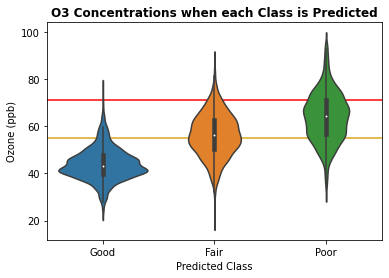

In [35]:
df_class0 = pd.DataFrame(O3val[Cpval == 0])
df_class1 = pd.DataFrame(O3val[Cpval == 1])
df_class2 = pd.DataFrame(O3val[Cpval == 2])

sb.violinplot(data = [O3val[Cpval == 0], 
                     O3val[Cpval == 1], 
                     O3val[Cpval == 2]])

plt.axhline(55, color='goldenrod', zorder=0)
plt.axhline(71, color='red', zorder=0)
plt.ylabel('Ozone (ppb)')
plt.xlabel('Predicted Class')
plt.xticks([0,1,2], ["Good", "Fair", "Poor"],)
plt.title('O3 Concentrations when each Class is Predicted', fontweight='demi')
plt.show()

# 4. Model Competition - Do Not Run

We have set aside a bunch of ozone data. Tune your model to the best of your abilities, and we will see how it performed at the end of class. Specifically, we will be using Weighted Categorical Accuracy to measure model performance. **EDIT the code below to test.**

In [36]:
CODE = '' # We will give you this at the end of class

DO NOT EDIT THE FOLLOWING:

In [37]:
def compete():

  # Read in data from url
  url = "https://raw.githubusercontent.com/eabarnes1010/course_ml_ats/main/data/ozone_data_joshuatreenp_" + CODE + ".csv"
  data = pd.read_csv(url,parse_dates=["DATE_TIME"],infer_datetime_format=True)

  # Fix data issue with Daylight Savings Time
  duplicate_dates = data['DATE_TIME'][data.duplicated('DATE_TIME')]
  for dup_date in duplicate_dates:
    idx = data['DATE_TIME'].eq(dup_date).idxmax()
    data.at[idx, 'DATE_TIME'] = dup_date - pd.Timedelta(value=1, unit='hours')  

  # Add hour and day of year
  data['HOUR'] = data['DATE_TIME'].dt.hour
  data['MONTH'] = data['DATE_TIME'].dt.month
  data['YEAR'] = data['DATE_TIME'].dt.year
  data['DAYOFYEAR'] = data['DATE_TIME'].dt.dayofyear
  data.sort_values('DATE_TIME', inplace=True, ignore_index = True)

  df_data_to_be_used = data[['OZONE'] + INPUT_VARIABLES] 
  df_data_to_be_used = df_data_to_be_used.rolling(8).mean()
  df_data_to_be_used[['DATE_TIME', 'HOUR', 'MONTH', 'YEAR']] = \
      data[['DATE_TIME', 'HOUR', 'MONTH', 'YEAR']] 
  df_data_to_be_used.dropna(inplace=True)

  Xcompete_raw = df_data_to_be_used[INPUT_VARIABLES].values
  output_raw = df_data_to_be_used['OZONE'].values
  hour = df_data_to_be_used['HOUR'].values
  month = df_data_to_be_used['MONTH'].values
  year = df_data_to_be_used['YEAR'].values

  output_class = (output_raw >= 55).astype(int) + (output_raw >= 71).astype(int)
  Tcompete = (output_class.reshape(-1,1) == np.unique(output_class)).astype(int)
  year_bool = lambda yrrange: np.logical_and(year>=yrrange[0], year<=yrrange[1])
  
  standardize_input = lambda dat, x, s: (dat - x)/s 
  Xcompete = standardize_input(Xcompete_raw, trainmean, trainstd)

  Pcompete = model.predict(Xcompete)
  Cpcompete = Pcompete.argmax(axis=1)
  Ctcompete = Tcompete.argmax(axis=1)

  cat_weights = np.sum((1 / np.mean(Ttrain, axis=0)) * Tcompete, axis=1) 
  print('Congrats! Your overall weighted categorical accuracy is:', accuracy_score(Ctcompete, Cpcompete, sample_weight=cat_weights) )
  print("Predicted versus Target Classes for Competition Data")
  confusion_matrix(Cpcompete, Ctcompete)

In [38]:
compete()

HTTPError: ignored